# Resilience Statistics for Soft Faults
We run experiments on how well the resilience strategies are able to correct soft faults by manually flipping bits and checking if they are recovered.
Let's introduce all the concepts with the Van der Pol equation.
To keep this notebook tidy, I wrote a class that contains functions for generating and processing statistics, which we first need to set up. Don't worry about the parameters for now, we will explain them as we go along.

In [1]:
from fault_stats import FaultStats, BaseStrategy, AdaptivityStrategy, IterateStrategy, run_piline, run_vdp
import matplotlib.pyplot as plt
import pySDC.helpers.plot_helper as plot_helper
plot_helper.setup_mpl(14, True)

vdp_stats = FaultStats(prob=run_vdp, strategies=[BaseStrategy(), AdaptivityStrategy(), IterateStrategy()],
                            faults=[False, True], reload=True, recovery_thresh=1 + 2e-2, num_procs = 1)

vdp_stats.run_stats_generation(runs=1000, step=50)

## What resilience strategies do we look at?
We test the following strategies:
 - base: Fixed iteration count and fixed step size
 - adaptivity: Fixed iteration count and adaptive step size
 - iterate: Adaptive iteration count and fixed step size
What sort of resilience do we expect from these strategies?

### Base scheme
Well, the base scheme does nothing to prevent faults, but a lot of faults don't really impact the solution, some not at all.
When using a set of quadrature nodes, where the right node corresponds to the interface, for instance, all faults occuring in the last iteration in any of the other nodes do not impact the solution, which is
$$
\frac{1}{N_\mathrm{iter}}\times\frac{N_\mathrm{coll}-1}{N_\mathrm{coll}} = \frac{1}{3}\times\frac{3}{4}= 25\,\%
$$
in our van der Pol example, so actually quite a significant amount!

Also, we solve the problem only to limited precision and perturbing the solution below this precision has no impact on the outcome as well.
We use `numpy.ndarray` to store the solution, which stores the individual floating point numbers in a 64 bit format.
The error of the fault-free runs, which we compute with a scipy reference solution by the way, is on the order of $10^{-6}$ and the precison of the double implementation goes down to about $10^{-11}$, so you can imagine that there are many bits which change the solution by less than we care about.
We call these insignificant bits and can determine experimentally from the plots below that all bits above about 35 are insignificant to us.

### Adaptivity
This scheme will restart the current step whenever an estimated error exceeds some predefined tolerance.
See [this notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/Adaptivity.ipynb) for details.
The tolerance is either not reached because the step size was too large, or because a fault occurred, both cases will lead to adaptivity refining the step size and trying again.
Don't worry!
We increase the step size again in the next step in case a fault occurred, because we will measure an error far below or tolerance.
This leads in principle to a rather resilient scheme, but the devil is in the implementation details.
One problem that we face here is that the faults are inserted after the error is estimated.
So if a bit in the last collocation node in the last iteration is flipped, we don't detect it, which in this case amounts to
$$
\frac{1}{N_\mathrm{iter}}\times \frac{1}{N_\mathrm{coll}}=\frac{1}{3}\times\frac{1}{4}\approx 8\,\%
$$
of faults.
Now, we could change the implementation, but in the real world, we cannot schedule when a fault happens exaclty, so I decided to leave this in as a reminder that none of this is ever going to be perfect.

### Iterate
TODO

### Hot Rod
TODO

### Faults we cannot fix
We have a large problem when the fault hits the initial conditions of a step, a.k.a. collocation node zero in the implementation in pySDC.
We may still converge to the solution of some problem, but it's not the problem we set out to solve!
In our example, this corresponds to
$$
\frac{1}{N_\mathrm{coll}}=\frac{1}{4} = 25\,\%
$$
of faults.
You might find some solace in that not all of them are actually bad.
If you have a fixed iteration count, such faults occuring in the last iteration fall under the no-impact category discussed in the base scheme, so for a fixed iteration scheme, we get only
$$
\frac{1}{N_\mathrm{coll}}\times\frac{N_\mathrm{iter}-1}{N_\mathrm{iter}}=\frac{1}{4} \times \frac{2}{3} \approx 16\,\%
$$
uncorrectable faults.
Additionally, quite a bit (in our case about half) are insignificant after all.

## How to decide whether a fault is recovered?
Unfortunately, there is no natural criterion for recovery of a fault.
What we decided to do is estimate the error at the end of the run and compare it to the error that we would get if no fault had occurred.
Since with some strategies we don't expect this to match exactly, we give some leeway, so we accept if
$$
e \leq \gamma e^*,
$$
where $\gamma \geq 1$ is the acceptance threshold and $e$ and $e^*$ are the errors of the run with faults and without faults respectively.
But what is a good value for $\gamma$?
We can make a plot how this changes the overall recovery rate and decide on a problem-specific basis:

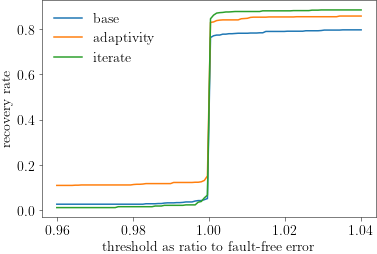

In [2]:
vdp_stats.plot_recovery_thresholds()

You can see that again, there is no abvious value we can read off of this plot, but we decide to be a bit forgiving with adaptivity and choose $\gamma=1.02$ here.
Actually, we already put this in above when we instantiated the `vdp_stats` object, but we "justify" this here.

## Which faults can be recovered?
We can now make some plots of the recovery rate depending on where the faults hit:

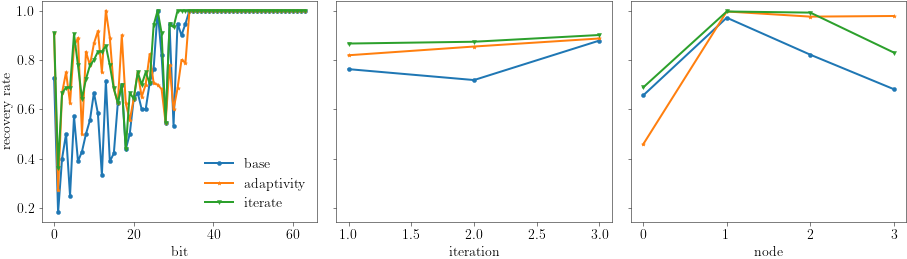

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
vdp_stats.plot_things_per_things('recovered', 'bit', op=vdp_stats.rec_rate, args={'ylabel': 'recovery rate'}, ax=axs[0])
vdp_stats.plot_things_per_things('recovered', 'iteration', op=vdp_stats.rec_rate, args={'ylabel': ''}, ax=axs[1])
vdp_stats.plot_things_per_things('recovered', 'node', op=vdp_stats.rec_rate, args={'ylabel': ''}, ax=axs[2])
axs[1].get_legend().remove()
axs[2].get_legend().remove()
fig.tight_layout()

In the above cell, we can see that 

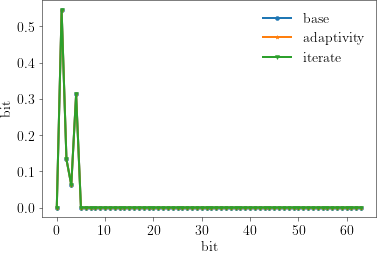

In [4]:
fig, ax = plt.subplots(1,1)
vdp_stats.plot_things_per_things('bit', 'bit', op=vdp_stats.crash_rate, ax=ax)

In [5]:
vdp_stats.scrutinize(vdp_stats.strategies[1], 0, False)

controller - INFO: Setup overview (--> user-defined) -- BEGIN
controller - INFO: ----------------------------------------------------------------------------------------------------

Controller: <class 'pySDC.implementations.controller_classes.controller_nonMPI.controller_nonMPI'>
--> mssdc_jac = False
    predict_type = None
    all_to_done = False
--> logger_level = 15
    log_to_file = False
    dump_setup = True
    fname = run_pid36314.log
    use_iteration_estimator = False
    store_uold = False
--> hook_class = <class 'fault_stats.log_fault_stats_data'>

Step: <class 'pySDC.core.Step.step'>
--> maxiter = 3
    Level: <class 'pySDC.core.Level.level'>
        Level  0
-->         dt = 0.01
            dt_initial = 0.01
            restol = -1.0
            nsweeps = 1
            residual_type = full_abs
-->         Problem: <class 'pySDC.implementations.problem_classes.Van_der_Pol_implicit.vanderpol'>
-->             mu = 5.0
-->             newton_tol = 1e-09
-->             ne

Adaptivity - Level 15: Adjusting step size from 5.03e-02 to 4.43e-02
Adaptivity - Level 15: Restarting: e=3.20e-05 >= e_tol=3.00e-05
hooks - INFO: Process  0 on time 0.394426 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 8.65522251e-04
hooks - INFO: Process  0 on time 0.394426 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.93812667e-05
hooks - INFO: Process  0 on time 0.394426 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 3.71578620e-07
Adaptivity - Level 15: Adjusting step size from 4.43e-02 to 4.51e-02
hooks - INFO: Process  0 on time 0.438770 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.18078347e-03
hooks - INFO: Process  0 on time 0.438770 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.83892065e-05
hooks - INFO: Process  0 on time 0.438770 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 6.3

hooks - INFO: Process  0 on time 0.833888 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.55578615e-03
hooks - INFO: Process  0 on time 0.833888 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.35026421e-05
hooks - INFO: Process  0 on time 0.833888 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 3.69865231e-07
Adaptivity - Level 15: Adjusting step size from 1.55e-02 to 1.49e-02
hooks - INFO: Process  0 on time 0.849437 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.58162495e-03
hooks - INFO: Process  0 on time 0.849437 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.33700656e-05
hooks - INFO: Process  0 on time 0.849437 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 3.59001794e-07
Adaptivity - Level 15: Adjusting step size from 1.49e-02 to 1.43e-02
hooks - INFO: Process  0 on time 0.864315 at stage  

hooks - INFO: Process  0 on time 1.041624 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.78034178e-05
hooks - INFO: Process  0 on time 1.041624 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.54765616e-07
Adaptivity - Level 15: Adjusting step size from 1.12e-02 to 1.19e-02
hooks - INFO: Process  0 on time 1.052855 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 2.11567185e-03
hooks - INFO: Process  0 on time 1.052855 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.51952230e-05
hooks - INFO: Process  0 on time 1.052855 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.00866294e-07
Adaptivity - Level 15: Adjusting step size from 1.19e-02 to 1.33e-02
hooks - INFO: Process  0 on time 1.064745 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 2.22131262e-03
hooks - INFO: Process  0 on time 1.064745 at stage  

hooks - INFO: Process  0 on time 1.180858 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.66155391e-05
hooks - INFO: Process  0 on time 1.180858 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 9.93545141e-07
Adaptivity - Level 15: Adjusting step size from 8.69e-03 to 1.04e-02
hooks - INFO: Process  0 on time 1.189550 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 9.46193897e-03
hooks - INFO: Process  0 on time 1.189550 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.79799046e-05
hooks - INFO: Process  0 on time 1.189550 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 2.50380875e-06
Adaptivity - Level 15: Adjusting step size from 1.04e-02 to 1.11e-02
hooks - INFO: Process  0 on time 1.199970 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.17113334e-02
hooks - INFO: Process  0 on time 1.199970 at stage  

hooks - INFO: Process  0 on time 1.273478 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.15272227e-05
hooks - INFO: Process  0 on time 1.273478 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 4.40971403e-08
Adaptivity - Level 15: Adjusting step size from 5.15e-03 to 5.19e-03
hooks - INFO: Process  0 on time 1.278628 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.02527495e-03
hooks - INFO: Process  0 on time 1.278628 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.12298321e-05
hooks - INFO: Process  0 on time 1.278628 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 6.84322300e-08
Adaptivity - Level 15: Adjusting step size from 5.19e-03 to 5.26e-03
hooks - INFO: Process  0 on time 1.283818 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 8.11465673e-04
hooks - INFO: Process  0 on time 1.283818 at stage  

hooks - INFO: Process  0 on time 1.375969 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 2.74382026e-07
Adaptivity - Level 15: Adjusting step size from 6.90e-03 to 6.71e-03
hooks - INFO: Process  0 on time 1.382865 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 2.04054965e-03
hooks - INFO: Process  0 on time 1.382865 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.40673063e-05
hooks - INFO: Process  0 on time 1.382865 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 2.81898587e-07
Adaptivity - Level 15: Adjusting step size from 6.71e-03 to 6.61e-03
hooks - INFO: Process  0 on time 1.389577 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.91930814e-03
hooks - INFO: Process  0 on time 1.389577 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.35672355e-05
hooks - INFO: Process  0 on time 1.389577 at stage  

Adaptivity - Level 15: Adjusting step size from 8.56e-03 to 8.89e-03
hooks - INFO: Process  0 on time 1.504253 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 9.62151430e-04
hooks - INFO: Process  0 on time 1.504253 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.12593165e-05
hooks - INFO: Process  0 on time 1.504253 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 4.75896315e-07
Adaptivity - Level 15: Adjusting step size from 8.89e-03 to 9.26e-03
hooks - INFO: Process  0 on time 1.513144 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 9.17603403e-04
hooks - INFO: Process  0 on time 1.513144 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.11753449e-05
hooks - INFO: Process  0 on time 1.513144 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 4.95062791e-07
Adaptivity - Level 15: Adjusting step size from 9.26

hooks - INFO: Process  0 on time 1.770217 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.72933520e-05
hooks - INFO: Process  0 on time 1.770217 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.28524316e-06
Adaptivity - Level 15: Adjusting step size from 3.66e-02 to 4.49e-02
hooks - INFO: Process  0 on time 1.806799 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.90731186e-04
hooks - INFO: Process  0 on time 1.806799 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.62178333e-05
hooks - INFO: Process  0 on time 1.806799 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.38383111e-06
Adaptivity - Level 15: Adjusting step size from 4.49e-02 to 5.77e-02
hooks - INFO: Process  0 on time 1.851684 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 1.46323528e-04
hooks - INFO: Process  0 on time 1.851684 at stage  

In [6]:
fixable = vdp_stats.get_mask()